In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Functions as AC
from scipy.stats import loguniform, uniform
from IPython.display import display, Math
import corner


## Description of System1 and System2 csv files

### Three parameters: 

$\quad$ -time_d: Time (days)

$\quad$ -rv_ms: Radial velocity (m/s)

$\quad$ -sig_rv_ms: Uncertainty on radial velocity measurements (m/s)

In [2]:
df1 = AC.data_loader('system1.csv')
df2 = AC.data_loader('system2.csv')

In [3]:
time1 = np.array(df1['time_d'])
rv1 = np.array(df1['rv_ms'])
sig1 = np.array(df1['sig_rv_ms'])

time2 = df2['time_d']
rv2 = df2['rv_ms']
sig2 = df2['sig_rv_ms']

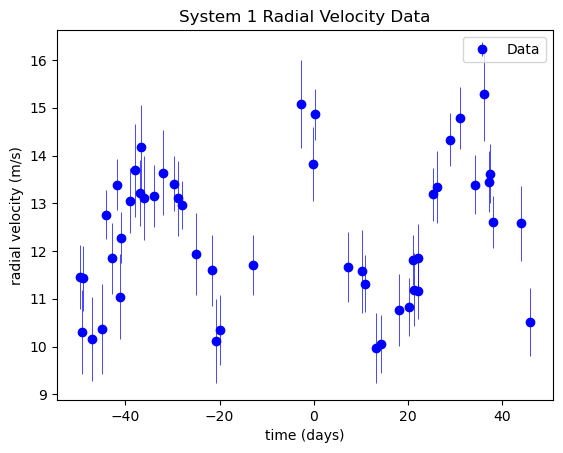

In [4]:
fig = plt.figure()
plt.errorbar(time1, rv1, yerr=sig1, elinewidth=.5, color='blue', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 1 Radial Velocity Data')
plt.legend()
plt.show()

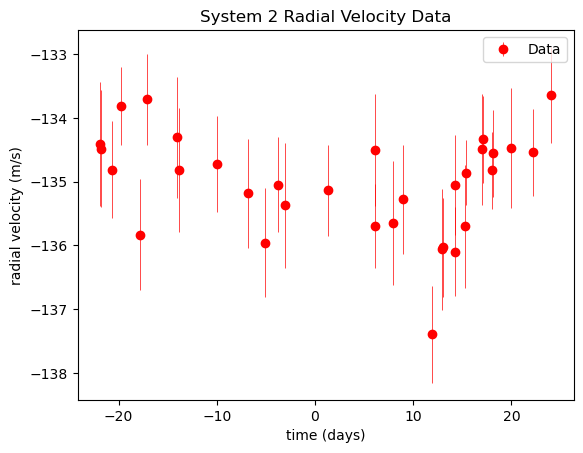

In [5]:
fig = plt.figure()
plt.errorbar(time2, rv2, yerr=sig2, elinewidth=.5, color='red', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 2 Radial Velocity Data')
plt.legend()
plt.show()

# The Forward Model

### Deriving the loglikelihood

Given a planet of mass m orbiting a star of mass M, with semi-major axis a, and eccentricity 0, the equation for the measured radial velocity of the system is:

$V(t) = V_0+K\cos(nt+\lambda_0)\;\;\;\;(1)\;\;$ where $\;\;K=\frac{m}{m+M}\frac{2\pi a\sin i}{P}\;\;$ is the radial velocity semi amplitude

The parameters of concern in this situation are $\theta=(V_0, K, \lambda_0)$

We can find an expression for the loglikelihood function:

Since we know that these measurements are affected by $\textbf{Uncorrelated Gaussian White Noise}$ we can compute the probability of the observation $v_k$ give $\theta$ as:

$p(v_k|\theta)=\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k;\theta))^2}{2\sigma_k^2}]\;\;\;\;(2)\;\;$

Since the GWN is uncorrelated this means that for each $v_k\;(1,...,k)$ given $\theta$ are independent so to get the total likelihood we simply multiply all probabilities together giving:

$\mathcal{L}=\prod_{k=1}^{N}[\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k))^2}{2\sigma_k^2}]]\;\;\;\;(3)\;\;$

$\because$ products are annoying to work with we can use properties of logs to get the loglikelihood as a summation as opposed to a product. Taking the natural log of both sides:

$ln\mathcal{L}=-\frac{1}{2}\sum_{k=1}^{N}[\frac{(v_k-V(t_k))^2}{\sigma_k^2}+ln(2\pi\sigma_k^2)]\;\;\;\;(4)\;\;$ Note $\;\;ln(2\pi\sigma_k^2)\;\;$ Doesn't depend on $\theta$


### Linearize V(t)

To start were given equation 1 for our formula for the radial velocity. We're then told that we can express that equation as:

$V(t)=A\cos(nt)+B\sin(nt)+C\;\;\;\;(5)\;\;$ where A, B, and C are constants

This linearization is advantageous to the original formula as it is linear as a function of t, meaning that it'll be easier to work with (i.e. fitting the function)

whereas the former has dependence on elements of $\theta$ that make it difficult to fit.

### Deriving A, B, and C

Lets now derive A, B, and C's dependence on the oribital/physical parameters

First note the trig identity: $\cos(\alpha+\beta)=\cos(\alpha)\cos(\beta)-\sin(\alpha)\sin(\beta)\;\;\;\;(6)\;\;$

Noticing that we can assign $\alpha=nt$ and $\beta=\lambda_0$ we get the following formulation of $V(t)$:

$V(t)=V_0+K(\cos(nt)\cos(\lambda_0)-\sin(nt)\sin(\lambda_0))\;\;\;\;(7)\;\;$

Organizing terms together as $\;\;V(t)=K\cos(\lambda_0)\cos(nt)-K\sin(\lambda_0)\sin(nt)+V_0\;\;\;\;(8)\;\;$ 

Notice how equation 8 matches the form of equation 5 with:

$\quad$ $\cdot\;A=K\cos(\lambda_0)$

$\quad$ $\cdot\;B=-K\sin(\lambda_0)$

$\quad$ $\cdot\;C=V_0$

# Calculating the Maximum Likelihood Estimator (MLE)

The MLE is defined as $\hat{\theta}=argmax_\theta\;\mathcal{L}_k(\theta;t)\;\;\;$ or in other words the values of theta that maximize the likelihood

We can express this minimizing $\;[ln(\sigma_k^2)+\frac{(v_k-V(t_k))^2}{\sigma_k^2}]=\sum_{k=1}^{N}\frac{(v_k-Ac_k-Bs_k-C)^2}{\sigma_k^2}\;\;\;$ where $\;\vec{c_k}\equiv\cos(nt_k)\;$ and $\;\vec{s_k}\equiv\sin(nt_k)$

And since the uncertainties are assumed from a normal distrubtuon we can use weighted least squares to maximize $\mathcal{L}$ and find $\hat{\theta}=(\hat{A}\;\hat{B}\;\hat{C})^T$

$\vec{v_k}=\vec{X}\theta+\epsilon\;\;\;$ where $\;\;\vec{v_k}=(v_1.....v_N)^T\;\;$ and $\;\;X=(\vec{c_k}\;\vec{s_k}\;\vec{1})$

$\vec{X}^T\vec{W}\vec{X}\hat{\theta}=\vec{X}^T\vec{W}\vec{v_k}\Rightarrow\hat{\theta}=(\vec{X}^T\vec{W}\vec{X})^{-1}\vec{X}^T\vec{W}\vec{v_k}$

Where $\vec{W}$ is a matrix with $\frac{1}{\sigma_k^2}$ on the diagonals


In [6]:
# time, rv, and uncertainty for k times
tk=time1 # (days)
vk=rv1 # (m/s)
sigk=np.array(sig1)

# Period and mean-motion
P = 33 # (days)
n=2*np.pi / P

# Columns of X
ck = np.cos(n*tk) 
sk = np.sin(n*tk)
ones = np.ones(len(tk))

# Make X and transpose of X
X = np.vstack((ck, sk, ones)).T
X_T= X.T

# Weighted diagonal matrix
W = np.diag(1 / sigk**2)

In [17]:
# Calculate maximum likelihood estimator for system 1 data
mle=np.linalg.inv(X_T@W@X)@X_T@W@rv1
print(mle)

# MLE parameters
A=mle[0]
B=mle[1]
C=mle[2]

[ 1.73312835 -0.39934569 12.35107417]


Now lets convert from A, B, and C to our orbital/physical parameters $(K, \lambda_0, V_0)$

Remember:

$\cdot\;A=K\cos(\lambda_0)$

$\cdot\;B=-K\sin(\lambda_0)$

$\cdot\;C=V_0$

To get K in terms of A and B, we take the square of A and B and add them together getting $A^2+B^2=K^2(\cos^2(\lambda_0)+\sin^2(\lambda_0))=K^2$

$\therefore\; K=\sqrt{A^2+B^2}$

Now to get $\lambda_0$ in terms of A and B, we can divide B by A giving $\frac{B}{A}=-\frac{K\sin(\lambda_0)}{K\cos(\lambda_0)}=-\tan(\lambda_0)$

$\therefore\; \lambda_0=\arctan(\frac{-B}{A})$

And of course $V_0=C$, so our job is done there

In [ ]:
K = np.sqrt(A**2+B**2)
lamb0=np.arctan(-B/A)
V0=C

display(Math(r'\text{The maximum likelihood estimate of } K, \lambda_0, \text{ and } V_0 \text{ are } K=' + str(K) +r'\text{, }'+ r'\lambda_0=' + str(lamb0)+r'\text{, }' +r'V_0=' + str(V0)))





<IPython.core.display.Math object>

# Metropolis-Hastings

### Bayes Theorem Review:

#### $p(\theta|y)=\frac{p(y|\theta)p(\theta)}{p(y)}\;\; ; \;\; p(y)=\int_{\theta\in\Theta}p(y|\theta)p(\theta)d\theta$


In [31]:
def logprior(theta):
    P, K, lamb0, V0 = theta

    logp = 0.0

    logp += loguniform.logpdf(P, 1.0, 1000.0)
    logp += loguniform.logpdf(K, 0.01, 100.0)
    logp += uniform.logpdf(lamb0, loc=0.0, scale=2*np.pi)
    logp += uniform.logpdf(V0, loc=-1e4, scale=2e4)

    return logp

def model(theta, t):
    P, K, lamb0, V0 = theta
    return V0 + K*np.cos((2*np.pi/P*t + lamb0))

def loglike(theta, t, v, sigma):
    model_v = model(theta, t)         
    residual   = v - model_v             
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2*np.pi*sigma**2))

In [54]:
def generate_proposal(theta, sigmas):

    theta = np.asarray(theta)
    sigmas = np.asarray(sigmas)

    step = np.random.normal(loc=0.0, scale=sigmas, size=theta.shape)
    return theta + step

theta_start = [33, K, lamb0, V0]
sigma_start = [0.02, 0.02, 0.01, 1.0]
theta_prop = generate_proposal(theta_start, sigma_start)
print(theta_start)
print(theta_prop)

[33, np.float64(1.778541775288376), np.float64(0.22646629702485993), np.float64(12.351074172134894)]
[33.0200514   1.80544179  0.21595275 10.10780778]


In [55]:
def mh_sampler(theta_start, sigma_start, nsamples):
    theta0 = np.asarray(theta_start, dtype=float)
    sigma0 = np.asarray(sigma_start, dtype=float)  
    length = len(theta0)

    # Where we will store indices of our Markov Chain
    chain = np.zeros((nsamples, length))
    chain[0] = theta0 # Set first link in the chain as the initial theta

    
    lnprior0 = logprior(theta0) # Calculate initial prior from proposed theta
    
    if not np.isfinite(lnprior0): # Handles priors outside range
        raise ValueError("Starting theta has -inf prior; choose a different starting point.")

    
    # Calculate the loglike and posterior for the initial proposal
    lnlike0 = loglike(theta0, time1, rv1, sig1)
    lnpost0 = lnprior0 + lnlike0

    # Sets proposal and acceptance counters
    n_accepted = 0
    n_proposed = 1 

    
    while n_proposed < nsamples:
        # Generate parameter proposal and calculate prior
        theta1 = generate_proposal(theta0, sigma0)
        lnprior1 = logprior(theta1)

        
        if not np.isfinite(lnprior1): # Checks if proposed prior is infinite
            chain[n_proposed] = theta0
            n_proposed += 1
            continue
        
        # Calculate likelihood and posterior of proposed theta
        lnlike1 = loglike(theta1, time1, rv1, sig1)
        lnpost1 = lnlike1 + lnprior1

        # Hastings Step: New posterior / Old posterior
        ratio = lnpost1 - lnpost0 


        rand_ln = np.log(np.random.uniform(0.0, 1.0))

        # If ratio is greater than the random number, we accept!!
        if ratio > rand_ln:
            n_accepted += 1

            # Swap inputs to newest value
            theta0 = theta1
            lnprior0, lnlike0, lnpost0 = lnprior1, lnlike1, lnpost1

        # Adds either the accepted theta to the chain or adds the proposed theta to the chain
        chain[n_proposed] = theta0
        n_proposed += 1

    accept_rate = n_accepted / (nsamples - 1)
    return chain, accept_rate


In [95]:
sigmas = [0.01, 0.01, 0.005, 0.5]
chain, acc = mh_sampler(theta_start, sigmas, 30000)

# OPTIONAL: Look up MCMC convergence test

[33.         33.         32.99445198 ... 33.28752363 33.28752363
 33.28752363]
0.22990766358878628


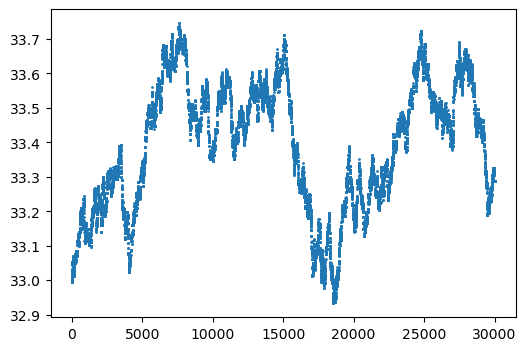

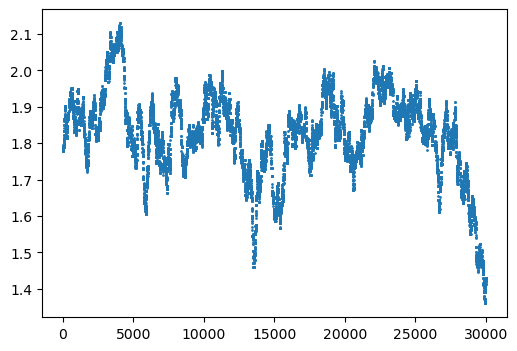

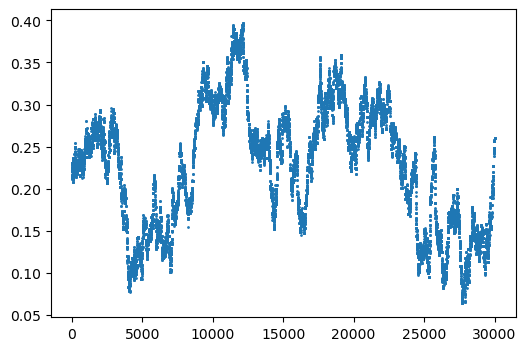

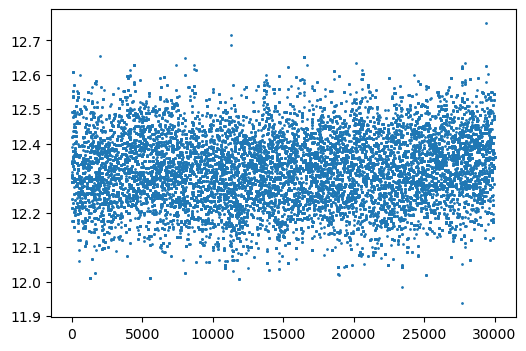

In [96]:
x = np.linspace(0, len(chain), len(chain))
print(chain[:, 0])
print(acc)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,0], s=1)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,1], s=1)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,2], s=1)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,3], s=1)

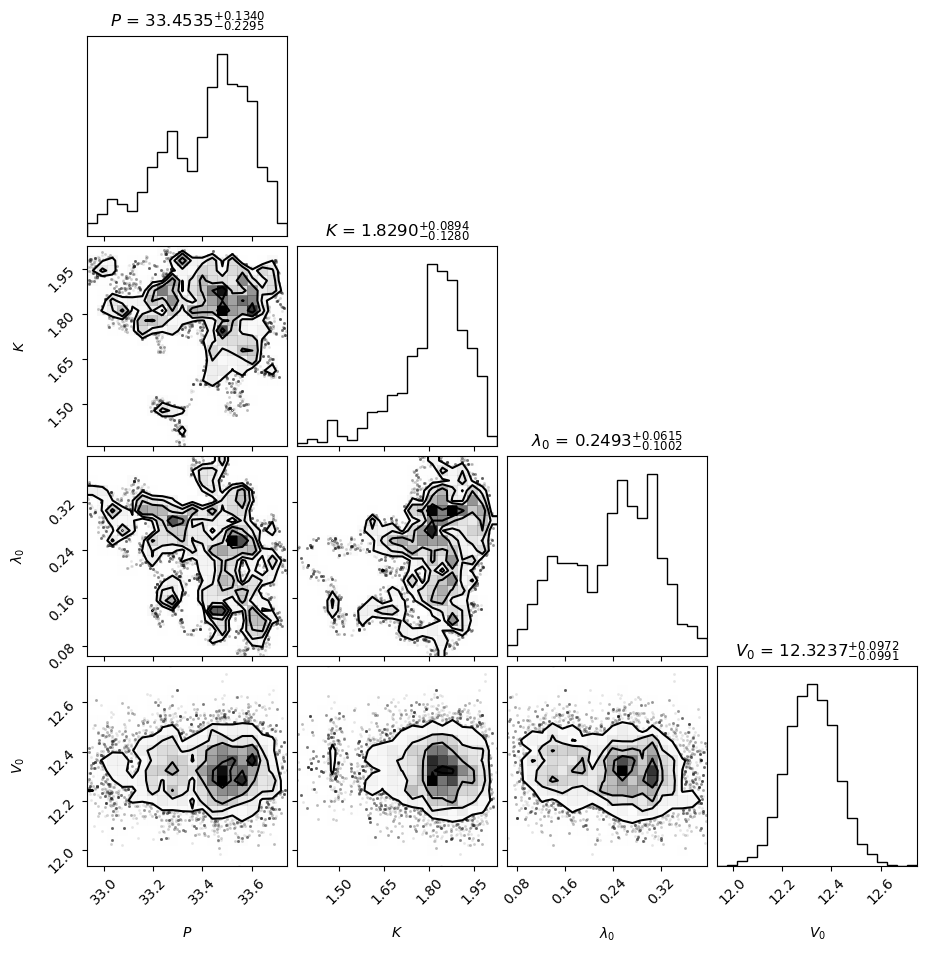

Posterior means:
P = 33.414238
K = 1.809803
λ0 = 0.238051
V0 = 12.323240


Posterior medians:
P = 33.453467
K = 1.828977
λ0 = 0.249318
V0 = 12.323709


In [107]:
nsamples = chain.shape[0]

# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

labels = [r"$P$", r"$K$", r"$\lambda_0$", r"$V_0$"]
fig = corner.corner(samples, labels=labels, show_titles=True, title_fmt=".4f")
plt.show() 

# Calculate posterior means and medians
post_mean   = np.mean(samples, axis=0)
post_median = np.median(samples, axis=0)

P_mean, K_mean, lam0_mean, V0_mean = post_mean
P_med, K_med, lam0_med, V0_med = post_median

# Print posterior means and medians
print("Posterior means:")
print(f"P = {P_mean:.6f}")
print(f"K = {K_mean:.6f}")
print(f"λ0 = {lam0_mean:.6f}")
print(f"V0 = {V0_mean:.6f}")
print('\n')
print("Posterior medians:")
print(f"P = {P_med:.6f}")
print(f"K = {K_med:.6f}")
print(f"λ0 = {lam0_med:.6f}")
print(f"V0 = {V0_med:.6f}")


In [ ]:
def min_mass(P, K, M):
    G = 6.67430e-11 
    return K * (P / (2 * np.pi * G))**(1/3) * M**(2/3)

nsamples = chain.shape[0]


# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

minimum_masses = []
for ii in range(len(samples)):
    M = 1.98847e30 # 1 Solar Mass
    P = samples[:, 0][ii] * 86400.0 # converts to seconds
    minimum_masses.append(min_mass(P, samples[:, 1][ii], M))
    
minimum_masses = np.asarray(minimum_masses)
M_earth  = 5.972e+24 
m = minimum_masses / M_earth

[9.01040884 8.86610694 8.86610694 ... 7.19021472 7.19021472 7.19021472]


minimum mass mean = 9.116002751898165 kg
minimum mass median = 9.211744504378624 kg


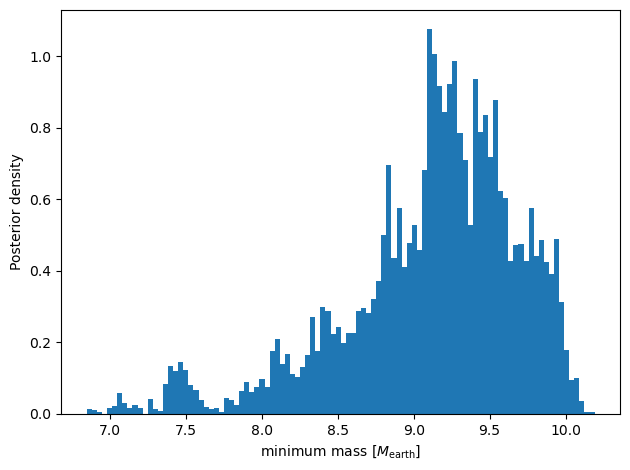

In [ ]:
min_mass_mean = np.mean(m)
min_mass_median = np.median(m)

print(f"minimum mass mean = {min_mass_mean} kg")
print(f"minimum mass median = {min_mass_median} kg")

# --- Histogram of m sin i ---
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.show()

In [152]:
alpha = 0.95
m = np.array(m)
sorted_m = np.sort(m)
n = len(sorted_m)


k = int(np.floor(alpha * n))


interval_widths = sorted_m[k:] - sorted_m[:n - k]

# index of the smallest-width interval
imin = np.argmin(interval_widths)

m_hpd_low  = sorted_m[imin]
m_hpd_high = sorted_m[imin + k]

print(f"Smallest 95% credible interval (HPD): [{m_hpd_low:.4f}, {m_hpd_high:.4f}]")

Smallest 95% credible interval (HPD): [7.9409, 10.0895]


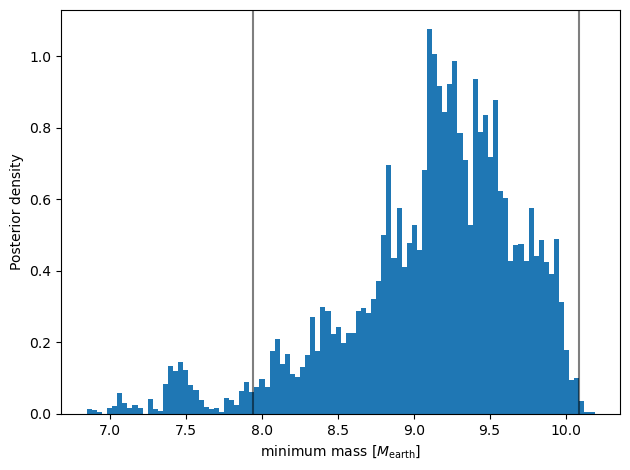

In [ ]:
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_hpd_low, color='black', alpha=.5)
plt.axvline(m_hpd_high, color='black', alpha=.5) 
plt.show()

Central 95% credible interval (equal tails): [7.4741, 9.9563]


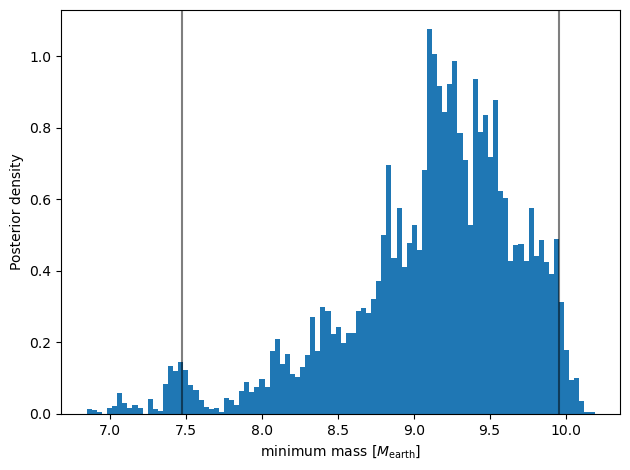

In [ ]:
m_low = np.percentile(m, 2.5)
m_high = np.percentile(m, 97.5)
print(f"Central 95% credible interval (equal tails): [{m_low:.4f}, {m_high:.4f}]")

plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_low, color='black', alpha=.5)
plt.axvline(m_high, color='black', alpha=.5) 
plt.show()